# Object Detection for ADAS Using YOLO on Thermal Images

## Introduction
Advanced Driver Assistance Systems (ADAS) enhance vehicle safety by providing real-time alerts and automated responses. Object detection is a critical component of ADAS, enabling the identification and tracking of various objects on the road, such as vehicles, pedestrians, and obstacles. 

In this project, we demonstrate the application of a YOLO (You Only Look Once) model trained on thermal images for object detection in challenging environmental conditions. This approach leverages thermal imaging to detect objects in scenarios where traditional RGB cameras may struggle, such as at night or in foggy conditions.

Below is a demonstration of the YOLO model detecting objects in a thermal video.


In [1]:
from IPython.display import Video
Video("Object detection demo video.mp4", width=640, height=480)

## Problem Statement

Object detection is a crucial component of Advanced Driver Assistance Systems (ADAS), which are designed to enhance vehicle safety by identifying and responding to various objects on the road. Traditional RGB cameras can struggle in certain conditions such as low light, fog, and glare, leading to potential safety risks.

Thermal imaging provides an alternative solution by detecting heat signatures, allowing for more reliable object detection in challenging environments. By training a YOLO model on thermal images, we aim to improve the robustness and accuracy of object detection for ADAS, ensuring better performance in adverse conditions.


## Dataset Description

The dataset used for training the YOLO model consists of thermal images from the FLIR ADAS dataset. This dataset is specifically designed for Advanced Driver Assistance Systems (ADAS) applications and contains annotated thermal images captured in various driving conditions.

- **Source**: FLIR ADAS Dataset
- **Number of Training Images**: 10,742
- **Number of Testing Images**: 1,145
- **Image Dimensions**: 640x512
- **Object Classes**: person, bike, car, motor, bus, train, truck, scooter, other_vehicle

### Dataset Details
The thermal images in the dataset capture heat signatures of objects, which are useful for detecting objects in low visibility conditions where traditional RGB cameras may struggle.

### Annotation Format
The dataset comes with an `index.json` file that includes all annotations in JSON format. The annotations are provided as bounding boxes with class labels.



###  Training Images

Below are five random training images from the dataset along with their annotations.


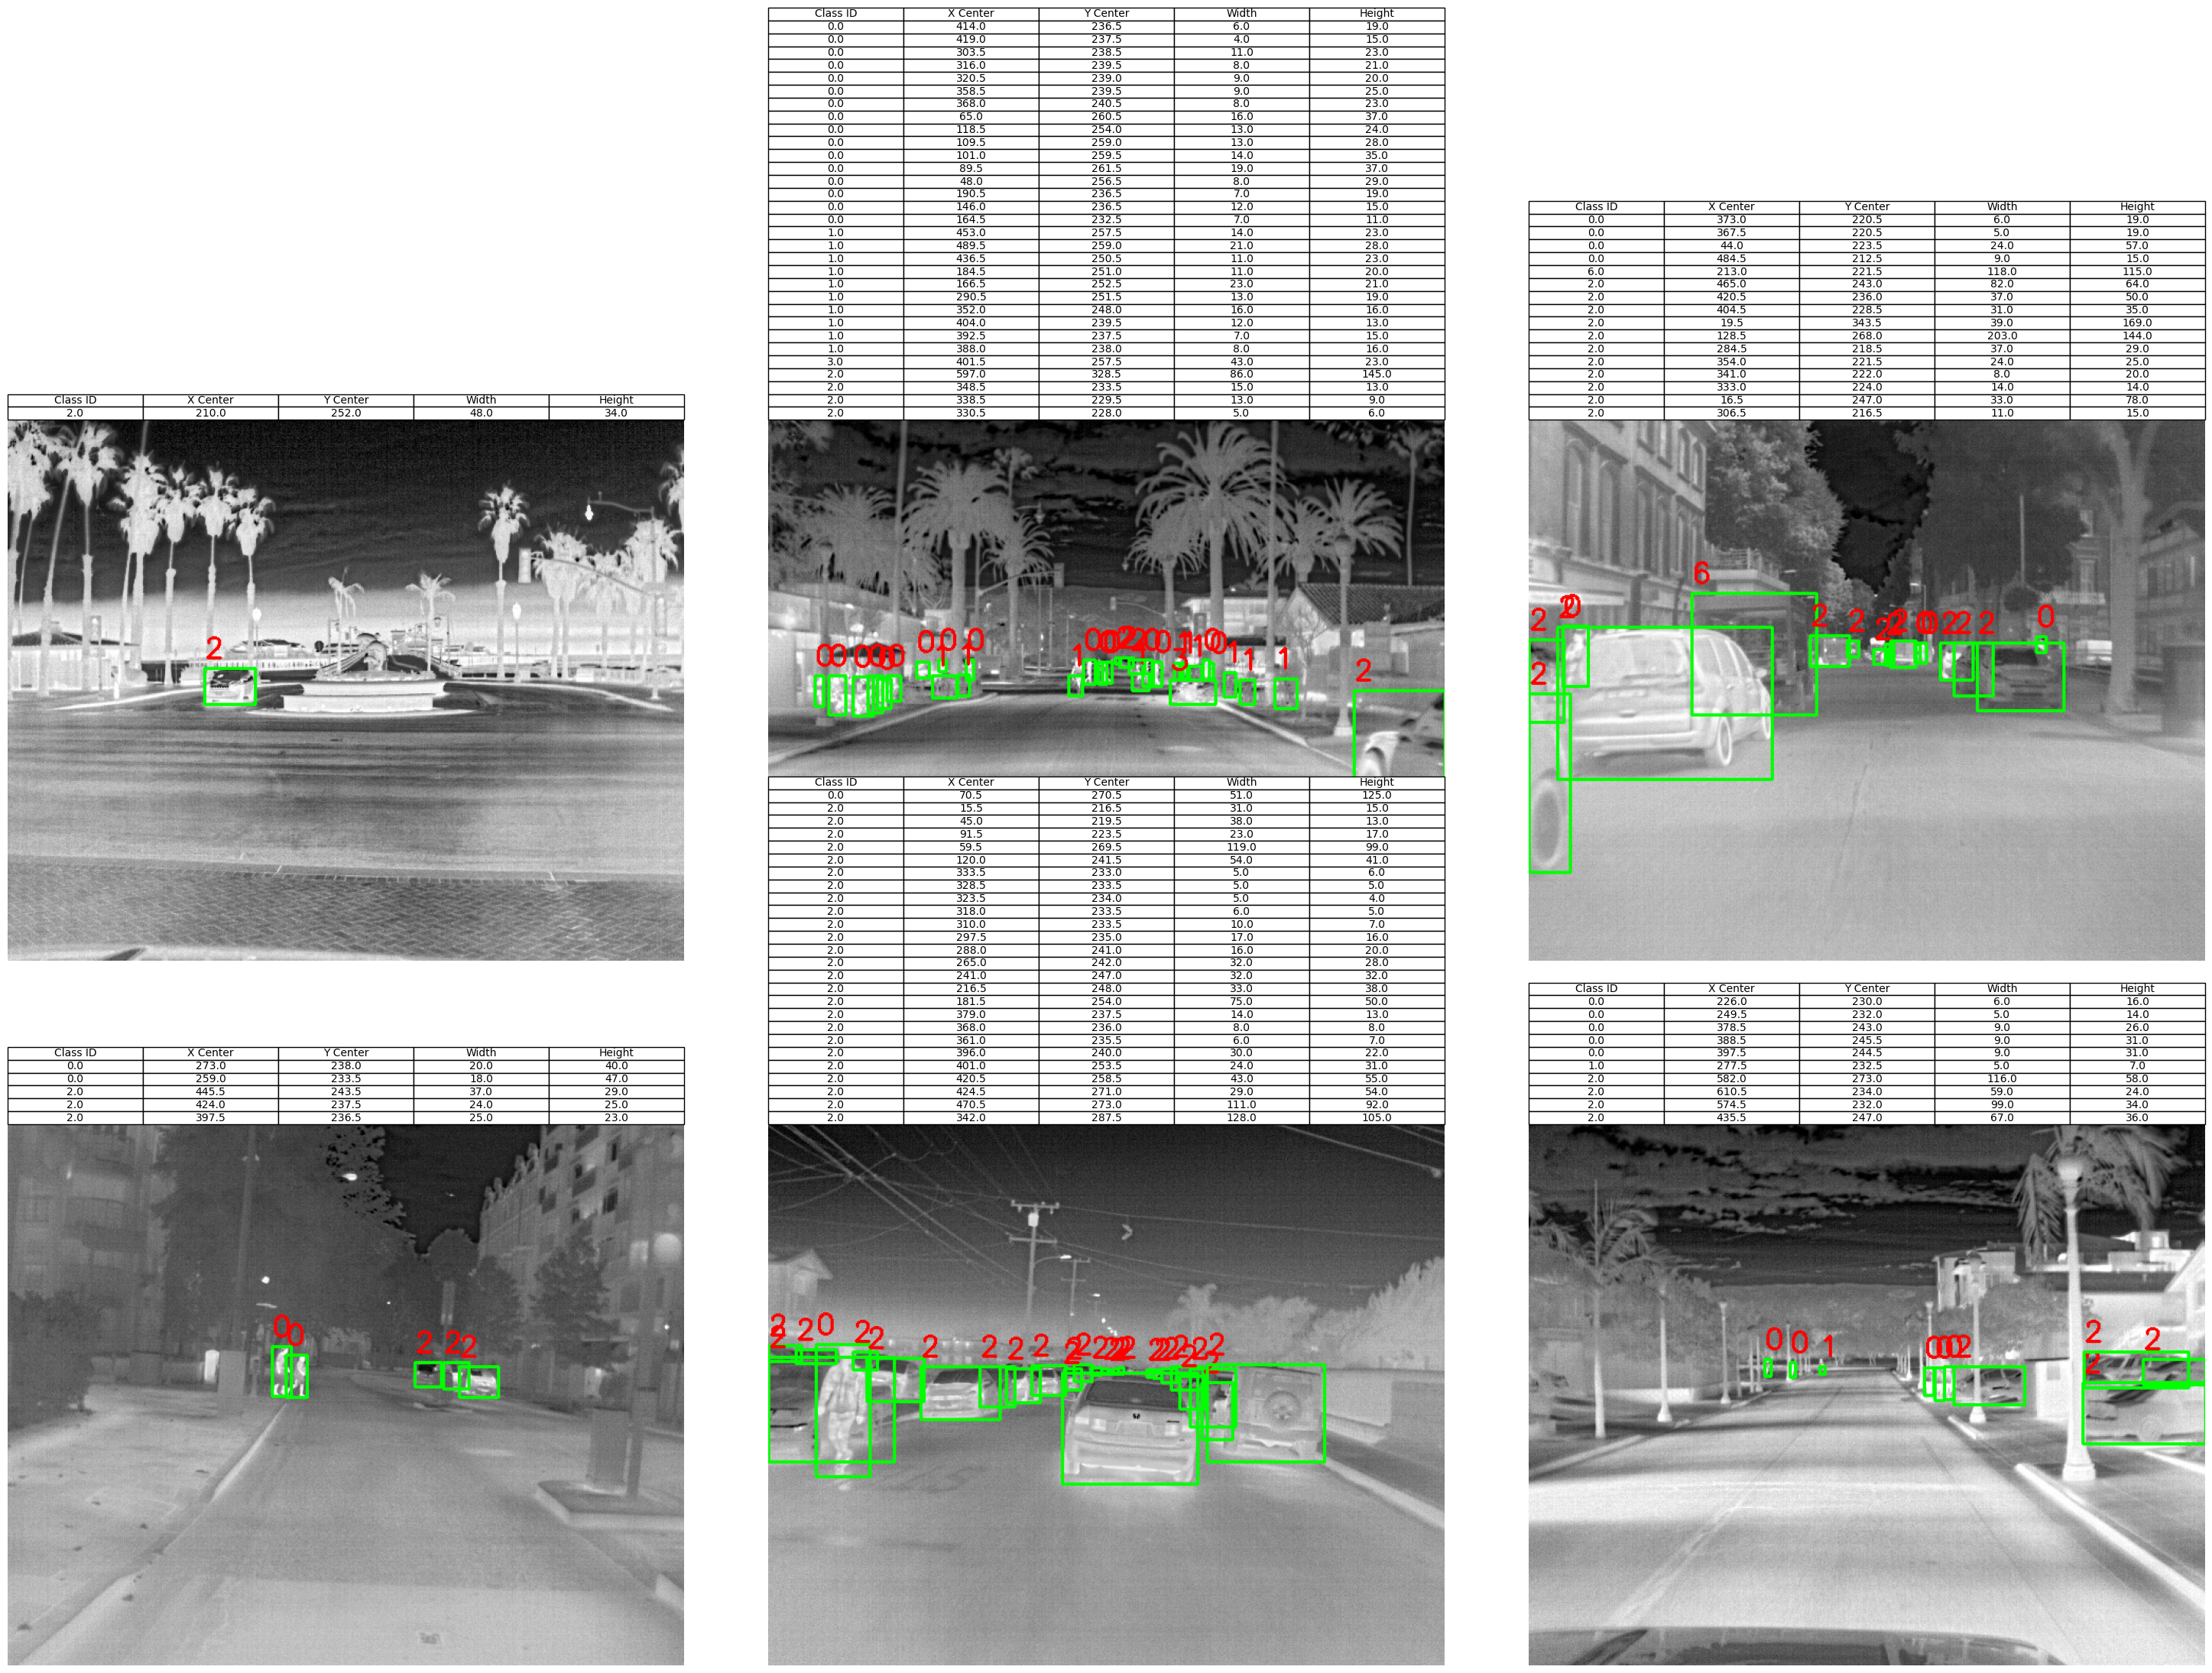

In [16]:
import os
import random
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from IPython.display import display, HTML

# Function to display an image with bounding boxes and annotations
def display_image_with_boxes_and_annotations(image_path, label_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    annotations = []
    with open(label_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            class_id, x_center, y_center, width, height = map(float, line.strip().split())
            img_height, img_width = image.shape[:2]
            x_center, y_center = x_center * img_width, y_center * img_height
            width, height = width * img_width, height * img_height
            x_min = int(x_center - width / 2)
            y_min = int(y_center - height / 2)
            x_max = int(x_center + width / 2)
            y_max = int(y_center + height / 2)
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            cv2.putText(image, str(int(class_id)), (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
            annotations.append([class_id, x_center, y_center, width, height])
    
    return image, annotations

# Directory paths
image_dir = 'dataset/images/train'
label_dir = 'dataset/labels/train'

# Get list of all image files
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

# Select 6 random images
random_images = random.sample(image_files, 6)

# Create a figure with 6 subplots (2 rows, 3 columns)
fig, axs = plt.subplots(2, 3, figsize=(30, 20))

# Display the random images with their annotations
for ax, image_file in zip(axs.flatten(), random_images):
    image_path = os.path.join(image_dir, image_file)
    label_path = os.path.join(label_dir, os.path.splitext(image_file)[0] + '.txt')
    image, annotations = display_image_with_boxes_and_annotations(image_path, label_path)
    
    # Display image
    ax.imshow(image)
    ax.axis('off')
    
    # Display annotations
    table_data = pd.DataFrame(annotations, columns=["Class ID", "X Center", "Y Center", "Width", "Height"])
    ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='top', cellLoc='center', colWidths=[0.2]*len(table_data.columns))

plt.tight_layout()
plt.show()


The images displayed above are six randomly selected training images from the dataset. Each image is annotated with bounding boxes that highlight detected objects, and a corresponding table is provided above each image detailing the annotations.

### What the Images and Annotations Show:

1. **Bounding Boxes**:
   - Each image contains bounding boxes around detected objects.
   - The bounding boxes are drawn in green with the class ID of the detected object labeled near the top-left corner of the box.

2. **Annotations Table**:
   - A table is provided above each image listing the details of the annotations.
   - The table includes the following columns:
     - **Class ID**: The integer ID of the detected class.
     - **X Center**: The normalized x-coordinate of the bounding box center.
     - **Y Center**: The normalized y-coordinate of the bounding box center.
     - **Width**: The normalized width of the bounding box.
     - **Height**: The normalized height of the bounding box.

### Example Explanation:
- **Class ID**: Identifies the type of object detected (e.g., person, car, etc.).
- **X Center**: Indicates the horizontal center of the bounding box relative to the image width.
- **Y Center**: Indicates the vertical center of the bounding box relative to the image height.
- **Width**: Represents the width of the bounding box as a fraction of the image width.
- **Height**: Represents the height of the bounding box as a fraction of the image height.

These images and their corresponding annotations provide a visual and quantitative understanding of the object detection results produced by the model.



## YOLO Dataset Structure

The YOLO dataset directory should be structured as follows:

<img src="utils/dataset structure.png" alt="Image" width="400" height="200"/>

- `images/`: Contains subfolders for training and validation images.
  - `train/`: Training images.
  - `val/`: Validation images.
- `labels/`: Contains subfolders for training and validation labels.
  - `train/`: YOLO format annotation files for training images.
  - `val/`: YOLO format annotation files for validation images.

Each label file in the `labels/train/` and `labels/val/` directories should contain annotations in the following format:

   
<img src="utils/annotation structure.png" alt="Image" width="400" height="200"/>    

Where:
- `<class_id>` is the integer ID of the class.
- `<x_center>` and `<y_center>` are the normalized coordinates of the bounding box center.
- `<width>` and `<height>` are the normalized width and height of the bounding box.


To use the dataset for training a YOLO model, the annotations were converted to the YOLO format using the following preprocessing script:

```python
import json
import os
import cv2

def create_yolo_training_dataset(image_directory, label_directory, json_file='index_train.json'):
    labels = [
        "person",
        "bike",
        "car",
        "motor",
        "bus",
        "train",
        "truck",
        "scooter",
        "other_vehicle"
    ]
    
    label_map = {label: idx for idx, label in enumerate(labels)}

    # Ensure the labels directory exists
    os.makedirs(label_directory, exist_ok=True)

    # Read the JSON file with annotations
    with open(json_file) as f:
        data = json.load(f)
        frames = data['frames']

        for frame in frames:
            image_name = f"video-{frame['videoMetadata']['videoId']}-frame-{str(frame['videoMetadata']['frameIndex']).zfill(6)}-{frame['datasetFrameId']}.jpg"
            image_path = os.path.join(image_directory, image_name)
            label_path = os.path.join(label_directory, f"{os.path.splitext(image_name)[0]}.txt")
            
            # Check if the image file exists before processing
            if os.path.isfile(image_path):
                img = cv2.imread(image_path)
                img_height, img_width = img.shape[:2]

                # Open the label file to write YOLO annotations
                with open(label_path, mode='w') as label_file:

                    # Extract annotations and write to YOLO file
                    for anno in frame["annotations"]:
                        label = anno['labels'][0]
                        if label in labels:
                            class_id = label_map[label]
                            bbox_height = anno["boundingBox"]["h"]
                            bbox_width = anno["boundingBox"]["w"]
                            x = anno["boundingBox"]["x"]
                            y = anno["boundingBox"]["y"]
                            
                            # Normalize the coordinates for YOLO
                            x_center = (x + bbox_width / 2) / img_width
                            y_center = (y + bbox_height / 2) / img_height
                            norm_width = bbox_width / img_width
                            norm_height = bbox_height / img_height

                            # Writing to YOLO label file: class id and normalized bounding box coordinates
                            label_file.write(f"{class_id} {x_center} {y_center} {norm_width} {norm_height}\n")
            
    # Ensure each image has a corresponding label file
    for image_name in os.listdir(image_directory):
        if image_name.endswith('.jpg'):
            label_path = os.path.join(label_directory, f"{os.path.splitext(image_name)[0]}.txt")
            if not os.path.exists(label_path):
                # Create an empty label file if it doesn't exist
                open(label_path, 'w').close()

    print("YOLO label files creation and validation complete.")

# Now you can call the function with the image directory path as a parameter:
create_yolo_training_dataset('data/images/train', 'data/labels/train', 'index_train.json')


## Model Overview

### YOLOv5

YOLOv5 is a state-of-the-art object detection model developed by Ultralytics. It is known for its accuracy and efficiency in real-time object detection tasks. YOLOv5 offers several model variants, including nano (n), small (s), medium (m), large (l), and extra-large (x), each designed to balance speed and accuracy according to different requirements.

### YOLOv5n (Nano Model)

The YOLOv5n model is the smallest and fastest variant in the YOLOv5 family. It is designed for deployment on edge devices and scenarios where computational resources are limited. Despite its compact size, YOLOv5n maintains good accuracy for many object detection tasks.

### Key Features of YOLOv5n

1. **Lightweight Architecture**: The nano model has fewer parameters and layers, making it highly efficient for fast inference.
2. **High Speed**: YOLOv5n is optimized for speed, allowing real-time detection even on devices with limited processing power.
3. **Good Accuracy**: While it sacrifices some accuracy compared to larger models, YOLOv5n still performs well on a variety of object detection benchmarks.

### Model Architecture

The YOLOv5n model architecture consists of the following components:

1. **Backbone**: A modified CSPDarknet53, which extracts features from the input images.
2. **Neck**: PANet (Path Aggregation Network), which combines features from different stages of the backbone to create a rich feature map.
3. **Head**: YOLO Layer, which predicts bounding boxes and class probabilities for object detection.

### Network Architecture of YOLOv5

Below is the network architecture of YOLOv5:

<img src="utils/model architecture.png" alt="Image" width="600" height="400"/>    


*Figure: The network architecture of YOLOv5. Source: [ResearchGate](https://www.researchgate.net/figure/The-network-architecture-of-Yolov5-It-consists-of-three-parts-1-Backbone-CSPDarknet_fig1_349299852)*

### Configuration File

The configuration for the YOLOv5n model can be found in the [Ultralytics YOLOv5 repository](https://github.com/ultralytics/ultralytics/blob/main/ultralytics/cfg/models/v5/yolov5.yaml). This configuration file defines the architecture and parameters of the YOLOv5n model, including the number of layers, the types of layers, and the specific settings used for training and inference.


## Model Training

### Introduction

In this section, we will train the YOLOv5n model on a custom thermal image dataset. The training process involves configuring the model, setting up the training parameters, and running the training script. We will also discuss the importance of using a GPU for training deep learning models.

### Importance of GPU Computing

Training deep learning models, especially complex ones like YOLOv5, requires significant computational resources. GPUs (Graphics Processing Units) are well-suited for this task due to their ability to perform parallel processing. Here are some reasons why GPU computing is essential:

1. **Parallel Processing**: GPUs can perform thousands of parallel operations, making them much faster than CPUs for tasks that require large-scale computations.
2. **Speed**: Using a GPU significantly reduces the training time for deep learning models. Training a model that might take days on a CPU can be completed in a few hours on a GPU.
3. **Efficiency**: GPUs are optimized for the kind of matrix and vector operations that are common in deep learning, making them more efficient than CPUs for these tasks.

### Training Configuration

For training the YOLOv5n model, we use the following configuration and parameters:

- **Image Size**: 640
- **Batch Size**: 16
- **Epochs**: 10
- **Data Configuration File**: `data.yaml`
- **Pre-trained Weights**: `yolov5n.pt`
- **Device**: GPU (CUDA)
- **Project Directory**: `runs/train`
- **Experiment Name**: `exp_model-n_img-640`

### Data Preparation

Before training the model, ensure that the dataset is correctly prepared and organized. The dataset should be divided into training and validation sets, with annotations converted to the YOLO format.

### Training Process

The training process involves the following steps:

1. **Cloning the YOLOv5 Repository**: Clone the YOLOv5 repository from GitHub to set up the training environment.
2. **Installing Dependencies**: Install the necessary dependencies for training the model.
3. **Setting Up the Data Configuration File**: Ensure that the `data.yaml` file is correctly set up with paths to the training and validation datasets.
4. **Running the Training Script**: Execute the training script with the specified parameters to train the model.

### Training Code

The following code snippet shows how to set up and train the YOLOv5n model using the Ultralytics repository:

```python
# Ensure you have the YOLOv5 repository and dependencies installed
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt

# Set up data.yaml file path
data_yaml_path = "data.yaml"  # Ensure this file is in the yolov5 directory or provide the correct path

# Train the YOLOv5n model
!python train.py --img 640 --batch 16 --epochs 10 --data {data_yaml_path} --weights yolov5n.pt --device 0 --project runs/train --name exp_model-n_img-640


## Room for Improvement

The current training setup uses a GTX 1050 GPU with 4GB of RAM. Training deep learning models is a computation-intensive task, and the current setup took approximately 3.5 hours to complete 10 epochs. There is a lot of room for improvement:

1. **More Powerful GPU**: Using a more powerful GPU with higher memory (e.g., RTX 2080, RTX 3080, or higher) can significantly reduce the training time and allow for more epochs and higher batch sizes.
2. **Higher Batch Size**: Increasing the batch size can improve the efficiency of the training process, but it requires more GPU memory.
3. **More Epochs**: Training for more epochs can improve the model's performance by allowing it to learn better representations.
4. **Parameter Tuning**: Tuning other hyperparameters, such as learning rate and optimizer settings, can also enhance the model's accuracy and efficiency.

## Monitoring Training

During the training process, you can monitor the progress through the logs printed in the console. The logs will provide information about the training and validation loss, accuracy, and other metrics. After training, the best model weights will be saved in the specified project directory.

## Conclusion

Training the YOLOv5n model on a custom thermal image dataset allows us to create a robust object detection system. Using a GPU for training significantly accelerates the process, making it feasible to train complex models within a reasonable time frame. In the next sections, we will evaluate the trained model and perform inference on new images.


## Model Evaluation

After training the YOLOv5n model, it's crucial to evaluate its performance to understand how well it detects and localizes objects in the thermal images. This section includes various evaluation metrics and visualizations to assess the model's accuracy and effectiveness.

### Evaluation Metrics

We use several metrics to evaluate the model's performance:

1. **Confusion Matrix**: Provides a summary of prediction results on the validation set, showing the true positive, false positive, false negative, and true negative rates for each class.
2. **Precision-Recall Curve**: Displays the trade-off between precision and recall for different thresholds.
3. **F1-Confidence Curve**: Shows the F1 score at different confidence levels.
4. **Precision-Confidence Curve**: Illustrates precision at various confidence levels.
5. **Recall-Confidence Curve**: Illustrates recall at various confidence levels.

### Evaluation Results

#### Confusion Matrix

The confusion matrix helps visualize the performance of the classification model by comparing actual and predicted labels.

<img src="yolov5/runs/train/exp_model-n_img-640/confusion_matrix.png" alt="Confusion Matrix" width="600"/>

*Figure: Confusion matrix showing the model's performance across different classes.*

#### F1-Confidence Curve

The F1-Confidence curve plots the F1 score at different confidence levels.

<img src="yolov5/runs/train/exp_model-n_img-640/F1_curve.png" alt="F1-Confidence Curve" width="600"/>

*Figure: F1-Confidence curve for different classes.*

#### Precision-Confidence Curve

The Precision-Confidence curve shows how precision changes with varying confidence thresholds.

<img src="yolov5/runs/train/exp_model-n_img-640/P_curve.png" alt="Precision-Confidence Curve" width="600"/>

*Figure: Precision-Confidence curve for different classes.*

#### Precision-Recall Curve

The Precision-Recall curve demonstrates the trade-off between precision and recall.

<img src="yolov5/runs/train/exp_model-n_img-640/PR_curve.png" alt="Precision-Recall Curve" width="600"/>

*Figure: Precision-Recall curve for different classes.*

#### Recall-Confidence Curve

The Recall-Confidence curve shows how recall varies with different confidence levels.

<img src="yolov5/runs/train/exp_model-n_img-640/R_curve.png" alt="Recall-Confidence Curve" width="600"/>

*Figure: Recall-Confidence curve for different classes.*

#### Labels Distribution and Correlogram

We also visualize the distribution of labels and their relationships using a correlogram.

<img src="yolov5/runs/train/exp_model-n_img-640/labels.jpg" alt="Labels Distribution" width="600"/>

*Figure: Distribution of instances per class in the dataset.*

<img src="yolov5/runs/train/exp_model-n_img-640/labels_correlogram.jpg" alt="Labels Correlogram" width="600"/>

*Figure: Correlogram showing the relationships between bounding box parameters (x, y, width, height).*

#### Training and Validation Losses

The following plots show the training and validation losses over epochs, as well as precision, recall, and mean Average Precision (mAP) metrics.

<img src="yolov5/runs/train/exp_model-n_img-640/results.png" alt="Training and Validation Results" width="600"/>

*Figure: Training and validation losses, precision, recall, and mAP over epochs.*




## Conclusion

The evaluation of the YOLOv5n model trained on the custom thermal image dataset reveals several insights into its performance. Here are the key takeaways based on the evaluation metrics and visualizations:

### Confusion Matrix
The confusion matrix shows that the model has varying degrees of accuracy across different classes. It performs well on classes like 'car' and 'person' but struggles with others such as 'motor' and 'bus'. This indicates that the model may need more training data or further tuning for underperforming classes.

### F1-Confidence Curve
The F1-confidence curve highlights that the model achieves its highest F1 scores at specific confidence levels for each class. The 'car' class, for example, shows a peak F1 score at a higher confidence level compared to other classes. This suggests that adjusting confidence thresholds per class could improve overall detection performance.

### Precision-Confidence Curve
The precision-confidence curve illustrates that the model maintains high precision for 'car' and 'person' classes at varying confidence levels, while precision drops significantly for classes like 'motor' and 'bus'. This further indicates the need for additional data or parameter tuning to improve precision for these classes.

### Precision-Recall Curve
The precision-recall curve demonstrates a trade-off between precision and recall. The model shows good precision and recall for the 'car' class but exhibits a significant drop for the 'motor' and 'bus' classes. Enhancing the training dataset with more examples of underrepresented classes could help improve these metrics.

### Recall-Confidence Curve
The recall-confidence curve shows that recall decreases with increasing confidence levels, especially for underperforming classes. This suggests that the model is better at identifying true positives at lower confidence levels, but this comes at the cost of higher false positives.

### Labels Distribution and Correlogram
The distribution of labels indicates a class imbalance, with the 'car' and 'person' classes having significantly more instances than others. The correlogram shows relationships between bounding box parameters, suggesting potential areas for optimization in bounding box predictions.

### Training and Validation Losses
The training and validation losses, along with precision, recall, and mAP metrics, show steady improvement over epochs. However, there is room for further improvement by running more epochs, using a more powerful GPU, and tuning hyperparameters.

### Overall Performance
Despite the computational limitations of using a GTX 1050 GPU with 4GB of RAM, the YOLOv5n model demonstrates reasonable performance on the custom thermal image dataset. The model's ability to accurately detect 'car' and 'person' classes is promising, but there is clear room for improvement for other classes. Using a more powerful GPU, increasing the number of training epochs, and fine-tuning hyperparameters could further enhance the model's performance.

The evaluation provides a solid foundation for understanding the YOLOv5n model's strengths and areas for improvement. In the next section, we will perform inference on new images using the trained model to demonstrate its practical application.


## Inference 

In this section, we will use the trained YOLOv5n model to perform inference on new thermal images. The objective is to demonstrate the model's practical application in detecting and localizing objects in unseen data.

### Inference Process

The inference process involves the following steps:
1. **Loading the Trained Model**: Load the trained YOLOv5n model with the best weights obtained during training.
2. **Preparing the Input Data**: Preprocess new images to match the input format expected by the model.
3. **Performing Inference**: Run the model on the new images to obtain predictions.
4. **Visualizing the Results**: Draw bounding boxes and labels on the images to visualize the detected objects.

### Loading the Trained Model

First, ensure that the YOLOv5 repository is set up and the necessary dependencies are installed. Then, load the trained model with the best weights obtained from custom data training.

```python
import cv2
import torch
import numpy as np
import os

# Load YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'custom', path=r'D:\Object Detection\yolov5\runs\train\exp_model-n_img-640\weights\last.pt', force_reload=True)

# Function to draw bounding boxes and labels
def draw_boxes(image, results):
    for pred in results.pred[0].detach().cpu().numpy():
        x1, y1, x2, y2, conf, cls = pred
        label = f"{model.names[int(cls)]} {conf:.2f}"
        
        # Draw bounding box
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)  # Change thickness here (last parameter)

        # Draw label
        (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)  # Adjust font size (third parameter) and thickness (fourth parameter)
        cv2.rectangle(image, (int(x1), int(y1) - 20), (int(x1) + w, int(y1)), (0, 255, 0), -1)
        cv2.putText(image, label, (int(x1), int(y1) - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)  # Adjust font size (third parameter) and thickness (fourth parameter)

# Path to test images
test_images_dir = r"D:\Object Detection\data_test"  # Use raw string notation
output_dir = r'D:\Object Detection\output_images_test_set'  # Use raw string notation

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# List all image files in the test images directory
image_files = [f for f in os.listdir(test_images_dir) if f.endswith(('.jpg', '.png'))]

# Debugging: Print the directory and files being processed
print(f"Processing images from directory: {test_images_dir}")
print(f"Found image files: {image_files}")

for image_file in image_files:
    image_path = os.path.join(test_images_dir, image_file)
    image = cv2.imread(image_path)

    # Debugging: Print the current image path being processed
    print(f"Processing image: {image_path}")

    # Apply the model to the image
    results = model(image)

    # Draw bounding boxes and labels
    draw_boxes(image, results)

    # Save the processed image
    output_image_path = os.path.join(output_dir, image_file)
    cv2.imwrite(output_image_path, image)

    # Display the image (optional)
    cv2.imshow('Processed Image', image)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()



### Visualizing the Results

The provided code performs the following steps:

1. **Loads the YOLOv5 Model**: Loads the trained YOLOv5n model from the specified path.
2. **Draws Bounding Boxes and Labels**: For each prediction, it draws bounding boxes and labels on the images.
3. **Processes Test Images**: Processes all images in the test directory, applies the model, and saves the output images with drawn bounding boxes and labels.
4. **Displays the Processed Images**: Optionally displays the processed images in a window.

### Example Inference

Here we show an example of running the inference on a set of new images and visualizing the results.

- **Test Images Directory**: `D:\Object Detection\data_test`
- **Output Images Directory**: `D:\Object Detection\output_images_test_set`

The code processes all images in the test images directory, draws bounding boxes and labels using the model predictions, and saves the processed images in the output directory. The processed images are displayed in a window, and pressing 'q' will close the window.


### Displaying Processed Images

Below we display a few of the processed images that were saved in the output directory after running the inference code. These images have bounding boxes and labels drawn on them to show the detected objects.


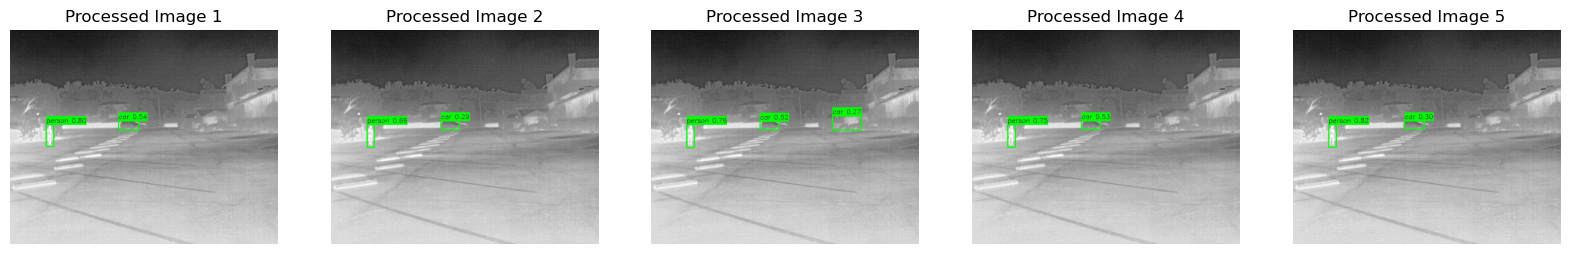

In [23]:
import os
import cv2
from matplotlib import pyplot as plt

# Define the path to the output directory
output_dir = r'D:\Object Detection\output_images_test_set'

# List all image files in the output directory
image_files = [f for f in os.listdir(output_dir) if f.endswith(('.jpg', '.png'))]

# Number of images to display
num_images_to_display = 5

# Create a subplot
fig, axs = plt.subplots(1, num_images_to_display, figsize=(20, 20))

# Display images in a row
for i, image_file in enumerate(image_files[:num_images_to_display]):
    image_path = os.path.join(output_dir, image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    axs[i].imshow(image)
    axs[i].set_title(f'Processed Image {i+1}')
    axs[i].axis('off')

plt.show()


## Conclusion

In this project, we developed an object detection system using the YOLOv5n model trained on a custom thermal image dataset. The following steps were undertaken to achieve our objectives:

### Data Preparation
- We prepared the dataset by converting annotations to the YOLO format and organizing the data into training and validation sets.

### Model Training
- We trained the YOLOv5n model using the prepared dataset. The training process involved configuring the model, setting hyperparameters, and running the training script on a GPU.
- Due to hardware constraints (GTX 1050 GPU with 4GB RAM), the training took approximately 3.5 hours for 10 epochs. However, with a more powerful GPU, the training time can be significantly reduced, and higher batch sizes and more epochs can be used for better performance.

### Model Evaluation
- We evaluated the model's performance using various metrics, including confusion matrix, precision-recall curves, F1-confidence curves, and training-validation loss plots.
- The model showed good performance in detecting and localizing objects like 'car' and 'person', but there was room for improvement for other classes such as 'motor' and 'bus'.

### Inference and Results
- We performed inference on new thermal images using the trained model. The model successfully detected and localized objects in the new images.
- The processed images were saved with bounding boxes and labels indicating the detected objects. We visualized these results to demonstrate the model's practical application.

### Key Takeaways
- **Effectiveness of YOLOv5n**: The YOLOv5n model proved to be effective for real-time object detection in thermal images, showcasing its potential for applications in autonomous driving, security, and surveillance.
- **GPU Utilization**: Leveraging a GPU for training deep learning models significantly accelerates the process, making it feasible to train complex models within a reasonable timeframe.
- **Model Improvement**: Despite the satisfactory performance, there is potential for further improvement by using a more powerful GPU, increasing the training data, and tuning hyperparameters.

### Recommendations for Future Work
1. **Enhance Dataset**:
   - Augment the dataset with more examples, especially for underrepresented classes like 'motor' and 'bus'.
2. **Use a More Powerful GPU**:
   - A GPU with higher memory (e.g., RTX 2080, RTX 3080) can significantly reduce training time and allow for higher batch sizes and more epochs.
3. **Tune Hyperparameters**:
   - Experiment with different learning rates, batch sizes, and other hyperparameters to optimize model performance.
4. **Class-specific Confidence Thresholds**:
   - Implement class-specific confidence thresholds to balance precision and recall better.

This project demonstrated the practical application of the YOLOv5n model for object detection in thermal images, providing a solid foundation for further improvements and real-world applications.
